In [70]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import json
import hvplot.pandas
import requests
#import tweepy
import yfinance as yf
import datetime

In [71]:
load_dotenv()

True

In [72]:
# # Twitter API keys
# api_key = os.getenv("TWITTER_API_KEY")
# api_secret = os.getenv("TWITTER_API_SECRET_KEY")
# access_token = os.getenv("ACCESS_TOKEN")
# access_secret = os.getenv("ACCESS_TOKEN_SECRET")
# bearer_token = os.getenv("TWITTER_BEARER_TOKEN")

# display(type(api_key))
# display(type(api_secrets))
# display(type(access_token))
# display(type(access_secret))
# display(type(bearer_token))

In [73]:
# use GET method and connect to API endpoint (Fear and Greed Index API)
r = requests.get('https://api.alternative.me/fng/?limit=0')

In [74]:
df = pd.DataFrame(r.json()['data'])
df

,value,value_classification,timestamp,time_until_update
0,20,Extreme Fear,1664841600,17932
1,24,Extreme Fear,1664755200,NaN
2,24,Extreme Fear,1664668800,NaN
3,20,Extreme Fear,1664582400,NaN
4,21,Extreme Fear,1664496000,NaN
...,...,...,...,...
1699,11,Extreme Fear,1517788800,NaN
1700,24,Extreme Fear,1517702400,NaN
1701,40,Fear,1517616000,NaN
1702,15,Extreme Fear,1517529600,NaN


In [75]:
# convert the value to an integer instead of an object
df['value'] = df.value.astype(int)

# convert timestamp to usable format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [76]:
df.dtypes

value                            int32
value_classification            object
timestamp               datetime64[ns]
time_until_update               object
dtype: object

In [77]:
# set index to timsetamp
df = df.set_index('timestamp')

In [78]:
df

,value,value_classification,time_until_update
timestamp,,,
2022-10-04,20,Extreme Fear,17932
2022-10-03,24,Extreme Fear,NaN
2022-10-02,24,Extreme Fear,NaN
2022-10-01,20,Extreme Fear,NaN
2022-09-30,21,Extreme Fear,NaN
...,...,...,...
2018-02-05,11,Extreme Fear,NaN
2018-02-04,24,Extreme Fear,NaN
2018-02-03,40,Fear,NaN


In [79]:
# plot to compare
df.hvplot(title = 'BTC Fear and Greed Index')

:Curve   [timestamp]   (value)

In [80]:
# reorganize data to oldest data points first
df = df[::-1]
df

,value,value_classification,time_until_update
timestamp,,,
2018-02-01,30,Fear,NaN
2018-02-02,15,Extreme Fear,NaN
2018-02-03,40,Fear,NaN
2018-02-04,24,Extreme Fear,NaN
2018-02-05,11,Extreme Fear,NaN
...,...,...,...
2022-09-30,21,Extreme Fear,NaN
2022-10-01,20,Extreme Fear,NaN
2022-10-02,24,Extreme Fear,NaN


In [81]:
btc_df = yf.download('BTC-USD')[['Close']]
btc_df.index.name = 'timestamp'

[*********************100%***********************]  1 of 1 completed


In [82]:
data_df = df.merge(btc_df, on ='timestamp')
data_df

,value,value_classification,time_until_update,Close
timestamp,,,,
2018-02-01,30,Fear,NaN,9170.540039
2018-02-02,15,Extreme Fear,NaN,8830.750000
2018-02-03,40,Fear,NaN,9174.910156
2018-02-04,24,Extreme Fear,NaN,8277.009766
2018-02-05,11,Extreme Fear,NaN,6955.270020
...,...,...,...,...
2022-09-29,22,Extreme Fear,NaN,19573.050781
2022-09-30,21,Extreme Fear,NaN,19431.789062
2022-10-01,20,Extreme Fear,NaN,19312.095703


In [83]:
# drop time_until_update column
data_df = data_df.drop(columns='time_until_update')

In [84]:
# add percent change column and drop the null value from the shift
data_df['pct_change'] = data_df['Close'].pct_change()

# drop the null value
data_df = data_df.dropna()
data_df['signal'] = [0] * len(data_df)
data_df.tail()

,value,value_classification,Close,pct_change,signal
timestamp,,,,,
2022-09-29,22,Extreme Fear,19573.050781,0.007532,0
2022-09-30,21,Extreme Fear,19431.789062,-0.007217,0
2022-10-01,20,Extreme Fear,19312.095703,-0.006160,0
2022-10-02,24,Extreme Fear,19044.107422,-0.013877,0
2022-10-03,24,Extreme Fear,19623.580078,0.030428,0


In [86]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df_model= data_df[[ 'Close', 'value']] 

df_model.head()

,Close,value
timestamp,,
2018-02-02,8830.750000,15
2018-02-03,9174.910156,40
2018-02-04,8277.009766,24
2018-02-05,6955.270020,11
2018-02-06,7754.000000,8


In [87]:
# Create a StandardScaler instance to scale df so we can overlay on a graph
scaler = StandardScaler()

# Fit the scaler to the features training dataset
scaled = scaler.fit_transform(df_model)

df_scaled = pd.DataFrame(scaled)
df_scaled = df_scaled.rename(columns = {0:"Close",1:"Fng"})

In [88]:
df_scaled

,Close,Fng
0,-0.672266,-1.228768
1,-0.652640,-0.126077
2,-0.703844,-0.831799
3,-0.779216,-1.405199
4,-0.733668,-1.537522
...,...,...
1697,-0.059680,-0.920015
1698,-0.067736,-0.964122
1699,-0.074561,-1.008230
1700,-0.089844,-0.831799


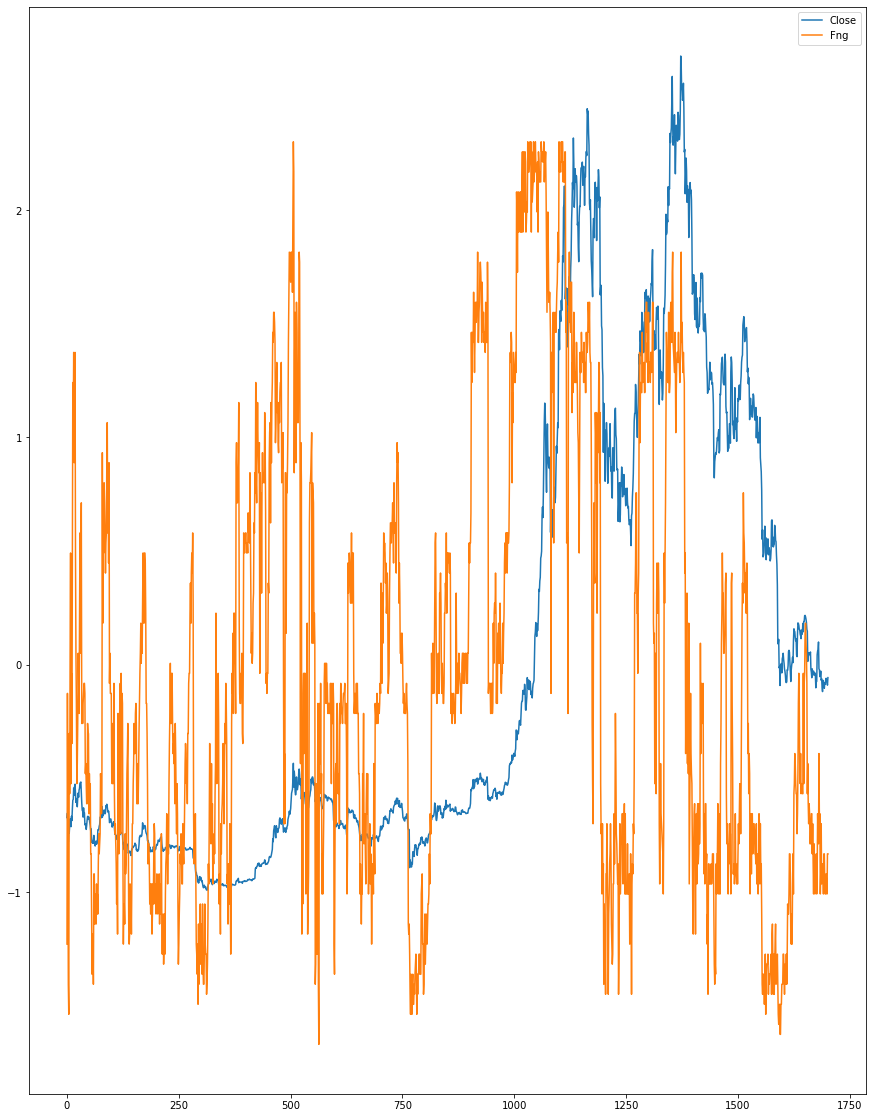

In [89]:
#look at a scaled graph overlaying both the closing price of BTC ang FNG
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_scaled.plot(ax = ax)
plt.show()


<AxesSubplot:>

<AxesSubplot:xlabel='timestamp'>

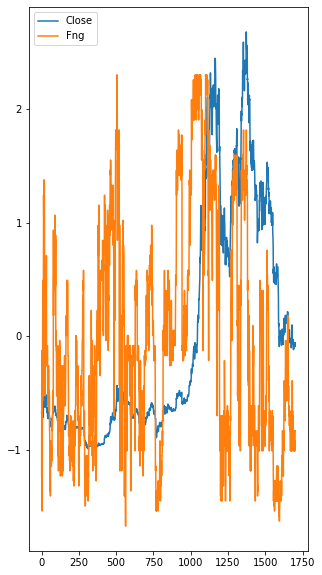

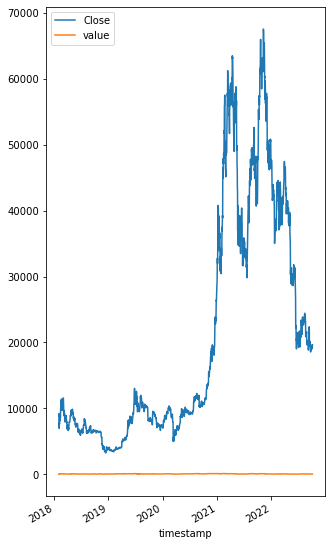

In [106]:
# fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (12,6))
display(df_scaled.plot(figsize =(5,10))) 
display(df_model.plot(figsize =(5,10)))


<AxesSubplot:xlabel='timestamp'>

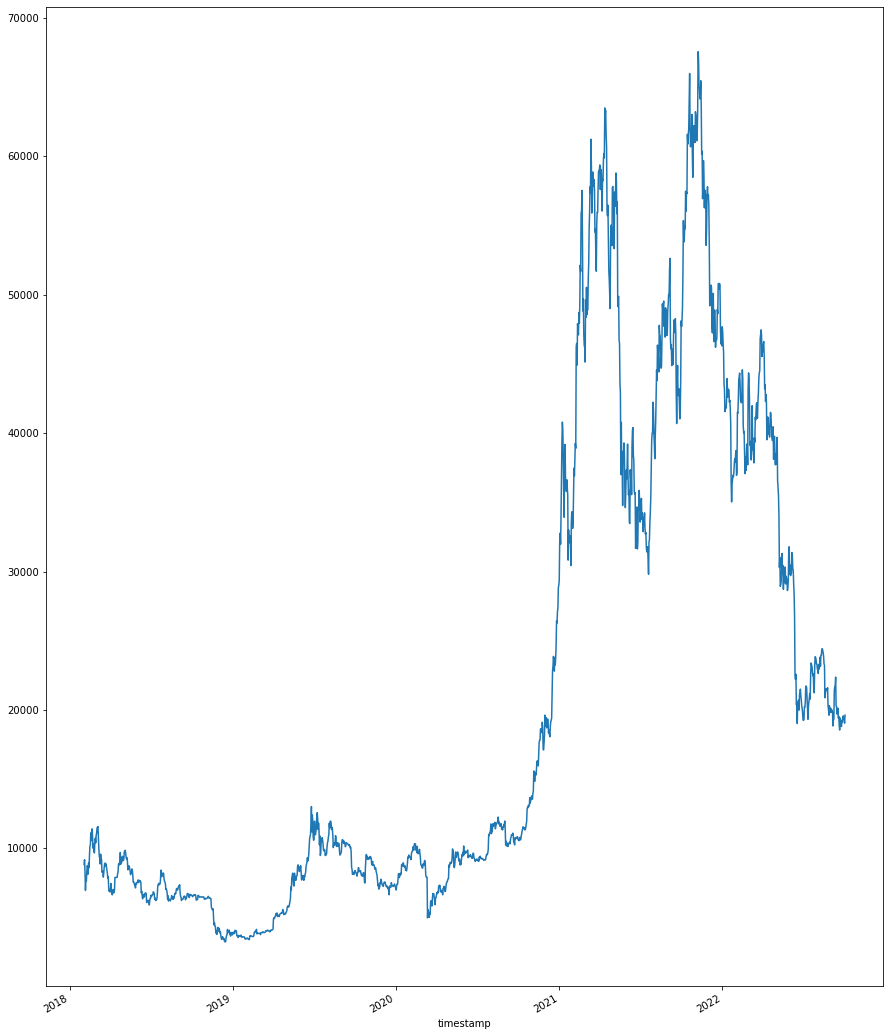

In [98]:
df_model["Close"].plot(figsize =(15,20))

Extreme Fear = 0-25
Fear = 26-46
Neutral = 47-54
Greed = 55-75
Extreme Greed = 76-100

X features = timestamp, value, close
y = signal

In [ ]:
data_df.value[-1]

In [ ]:
if data_df.value[-1] < data_df.value[-5] and data_df.value[-1] <=75 and data_df.value[-5] >75:
    signal[-1] = 1 #signal to sell since fng is falling below 75
    


In [ ]:
for row in range(0, len(df)):
    if data_df.value[row] < data_df.value[row-1] and data_df.value[row] <=75 and data_df.value[row-1] >75:
        signal[row] = 1 #signal to sell since fng is falling below 75
    
    if data_df.value[row] < data_df.value[row-1] and data_df.value[row] <= 54 and data_df.value[row-1] > 54:
        signal[row] = 1 #signal to sell since fng is falling before 54
        
    if data_df.value[row] < data_df.value[row-1] and data_df.value[row] <= 46 and data_df.value[row-1] > 46:
        signal[row] = 1 #signal to sell since fng is falling before 46

In [33]:
data_df['Change'] = data_df['value_classification'].ne(data_df['value_classification'].shift().bfill()).astype(int)

data_df

,value,value_classification,Close,pct_change,Change
timestamp,,,,,
2018-02-02,15,Extreme Fear,8830.750000,-0.037052,0
2018-02-03,40,Fear,9174.910156,0.038973,1
2018-02-04,24,Extreme Fear,8277.009766,-0.097865,1
2018-02-05,11,Extreme Fear,6955.270020,-0.159688,0
2018-02-06,8,Extreme Fear,7754.000000,0.114838,0
...,...,...,...,...,...
2022-09-29,22,Extreme Fear,19573.050781,0.007532,0
2022-09-30,21,Extreme Fear,19431.789062,-0.007217,0
2022-10-01,20,Extreme Fear,19312.095703,-0.006160,0


In [17]:
# when FG is below 25 buy BTC (Extreme Fear)

# when FG rises to 26 buy BTC (Fear)

# when FG rises to 47 buy BTC (Neutral)

# when FG rises to 55 buy BTC (Greed)

#################################

# when FG declines to 75 sell BTC (Greed)

# when FG declines to 54 sell BTC (Neutral)

# when FG declines to 46 sell BTC (Fear)

# when FG declines to 25 sell BTC (Extreme Fear)

# for row in data_df:
#     if row['value'] < 25
#         row['Signal'] = 1
        
#     elif row['value'] == 26

SyntaxError: invalid syntax (1638192129.py, line 20)